<a href="https://colab.research.google.com/github/xromeo/MSDC/blob/main/Retrain_SRGAN_0_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 with open('/content/drive/My Drive/foo.txt', 'w') as f:
   f.write('Hello Google Drive!')
 !cat /content/drive/My\ Drive/foo.txt

Hello Google Drive!

In [ ]:

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, PReLU, UpSampling2D, Dense, LeakyReLU, Input, Flatten
from tensorflow.keras.models import Sequential, Model



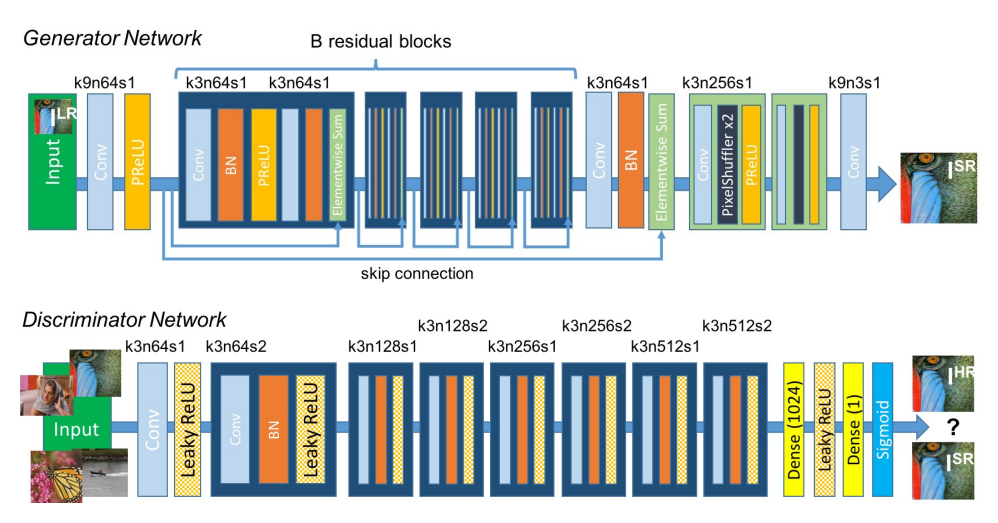

In [ ]:
def residual_block(input):
    res_model = Conv2D(64, (3, 3), padding="same")(input)
    res_model = BatchNormalization(momentum=0.5)(res_model)
    res_model = PReLU(shared_axes=[1, 2])(res_model)

    res_model = Conv2D(64, (3, 3), padding="same")(res_model)
    res_model = BatchNormalization(momentum=0.5)(res_model)

    return tf.keras.layers.Add()([input, res_model])


def upscale_block(input):
    upscale_model = Conv2D(256, (3, 3), padding="same")(input)
    upscale_model = UpSampling2D(size=2)(upscale_model)
    upscale_model = PReLU(shared_axes=[1,2])(upscale_model)

    return upscale_model

In [ ]:
def create_generator(generator_input, num_residual_block):
    generator_filters = 64

    generator_layers = Conv2D(generator_filters, (9, 9), padding="same")(generator_input)
    generator_layers = PReLU(shared_axes=[1, 2])(generator_layers)

    skip_connection = generator_layers

    for _ in range(num_residual_block):
        generator_layers = residual_block(generator_layers)

    generator_layers = Conv2D(generator_filters, (3, 3), padding="same")(generator_layers)
    generator_layers = BatchNormalization(momentum=0.5)(generator_layers)
    generator_layers = tf.keras.layers.Add()([generator_layers, skip_connection])

    generator_layers = upscale_block(generator_layers)
    generator_layers = upscale_block(generator_layers)

    generator_output = Conv2D(3, (9, 9), padding="same")(generator_layers)

    return tf.keras.Model(inputs=generator_input, outputs=generator_output)



In [ ]:
def discriminator_block(input, filters, strides=1, withBatchNormalization=True):
    discriminator_model = Conv2D(filters, (3, 3), strides=strides, padding="same")(input)

    if withBatchNormalization:
        discriminator_model = BatchNormalization(momentum=0.8)(discriminator_model)

    discriminator_model = LeakyReLU(alpha=0.2)(discriminator_model)

    return discriminator_model

In [ ]:

def create_discriminator(discriminator_input):
    discriminator_filters = 64

    disc_layers1 = discriminator_block(discriminator_input, discriminator_filters, withBatchNormalization=False)
    disc_layers2 = discriminator_block(disc_layers1, discriminator_filters, strides=2)
    disc_layers3 = discriminator_block(disc_layers2, discriminator_filters * 2)
    disc_layers4 = discriminator_block(disc_layers3, discriminator_filters * 2, strides=2)
    disc_layers5 = discriminator_block(disc_layers4, discriminator_filters * 4)
    disc_layers6 = discriminator_block(disc_layers5, discriminator_filters * 4, strides=2)
    disc_layers7 = discriminator_block(disc_layers6, discriminator_filters * 8)
    disc_layers8 = discriminator_block(disc_layers7, discriminator_filters * 8, strides=2)

    disc_flatten = Flatten()(disc_layers8)
    disc_dense1 = Dense(discriminator_filters * 16)(disc_flatten)
    disc_leaky_relu = LeakyReLU(alpha=0.2)(disc_dense1)
    discriminator_output = Dense(1, activation='sigmoid')(disc_leaky_relu)

    return tf.keras.Model(inputs=discriminator_input, outputs=discriminator_output)


In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19

def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet", include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)


In [ ]:
def build_combined_model(generator_model, discriminator_model, vgg_model, lr_input, hr_input):
    generated_image = generator_model(lr_input)

    generated_features = vgg_model(generated_image)

    discriminator_model.trainable = False
    validity = discriminator_model(generated_image)

    combined_model = tf.keras.Model(inputs=[lr_input, hr_input], outputs=[validity, generated_features])

    return combined_model


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

base_path = "/content/drive/My Drive"
dataset_path = os.path.join(base_path, "dataset")
train_hr_path = os.path.join(dataset_path, "train/hr")
train_lr_path = os.path.join(dataset_path, "train/lr")
test_hr_path = os.path.join(dataset_path, "test/hr")
test_lr_path = os.path.join(dataset_path, "test/lr")

In [ ]:
def get_train_data():
    X = []
    Y = []

    if not os.path.exists(train_lr_path) or not os.path.exists(train_hr_path):
        raise ValueError("Training directories not found")

    train_lr_files = sorted(os.listdir(train_lr_path))  # Sort the file names
    train_hr_files = sorted(os.listdir(train_hr_path))  # Sort the file names

    if len(train_lr_files) != len(train_hr_files):
        raise ValueError("Number of LR and HR training images do not match")

    for x, y in zip(train_lr_files, train_hr_files):
        img_x = cv2.imread(os.path.join(train_lr_path, x))
        img_x = cv2.cvtColor(img_x, cv2.COLOR_BGR2RGB)

        img_y = cv2.imread(os.path.join(train_hr_path, y))
        img_y = cv2.cvtColor(img_y, cv2.COLOR_BGR2RGB)

        if img_x is None or img_y is None:
            raise ValueError(f"Failed to read LR or HR image: {x}, {y}")

        X.append(img_x)
        Y.append(img_y)

    X = np.array(X)
    Y = np.array(Y)

    return X, Y

train_lr, train_hr = get_train_data()

print(train_hr.shape)
print(train_lr.shape)


(960, 256, 256, 3)
(960, 64, 64, 3)


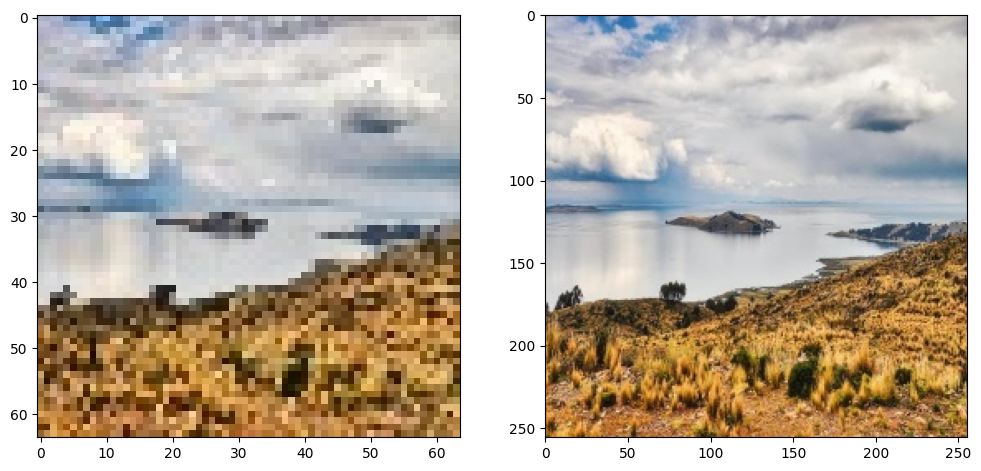

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(train_lr)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(train_lr[image_number], (64, 64, 3)))
plt.subplot(122)
plt.imshow(np.reshape(train_hr[image_number], (256, 256, 3)))
plt.show()

In [ ]:
#Scale values
train_lr = train_lr / 255.
train_hr = train_hr / 255.

In [ ]:
def get_test_data():
    X = []
    Y = []

    if not os.path.exists(test_lr_path) or not os.path.exists(test_hr_path):
        raise ValueError("Training directories not found")

    test_lr_files = sorted(os.listdir(test_lr_path))  # Sort the file names
    test_hr_files = sorted(os.listdir(test_hr_path))  # Sort the file names

    if len(test_lr_files) != len(test_hr_files):
        raise ValueError("Number of LR and HR training images do not match")

    for x, y in zip(test_lr_files, test_hr_files):
        img_x = cv2.imread(os.path.join(test_lr_path, x))
        img_x = cv2.cvtColor(img_x, cv2.COLOR_BGR2RGB)

        img_y = cv2.imread(os.path.join(test_hr_path, y))
        img_y = cv2.cvtColor(img_y, cv2.COLOR_BGR2RGB)

        if img_x is None or img_y is None:
            raise ValueError(f"Failed to read LR or HR image: {x}, {y}")

        X.append(img_x)
        Y.append(img_y)

    X = np.array(X)
    Y = np.array(Y)

    return X, Y

test_lr, test_hr = get_test_data()

print(test_hr.shape)
print(test_lr.shape)


(20, 256, 256, 3)
(20, 64, 64, 3)


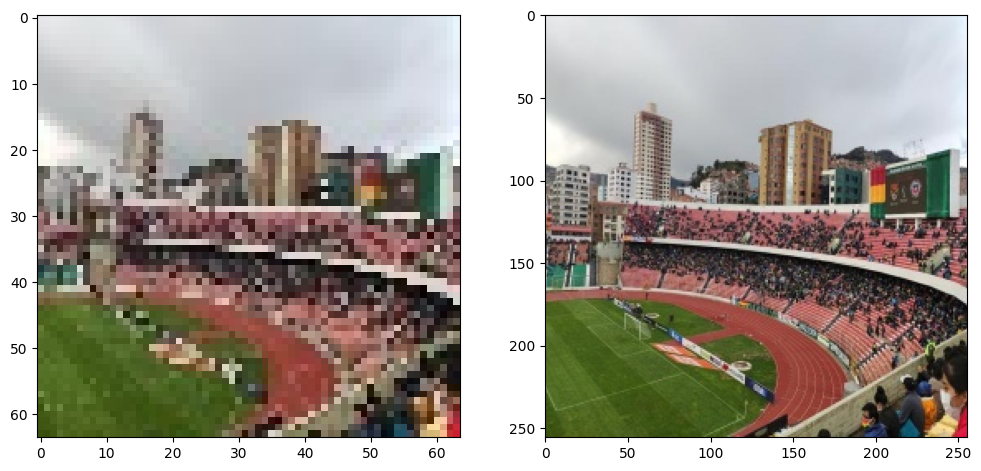

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(test_lr)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(test_lr[image_number], (64, 64, 3)))
plt.subplot(122)
plt.imshow(np.reshape(test_hr[image_number], (256, 256, 3)))
plt.show()

In [ ]:
#Scale values
test_lr = test_lr / 255.
test_hr = test_hr / 255.

In [ ]:
num_residual_block = 16

# shape (625, 64, 64, 3) we need (64, 64, 3)
hr_shape = train_hr.shape[1:]
lr_shape = train_lr.shape[1:]

lr_input = Input(shape=lr_shape)
hr_input = Input(shape=hr_shape)

print ("Input generator shape = ", lr_shape)
print ("Input discriminator shape = ", hr_shape)

Input generator shape =  (64, 64, 3)
Input discriminator shape =  (256, 256, 3)


In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam


In [ ]:
generator = create_generator(lr_input, num_residual_block)
#generator.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

#generator.summary()

discriminator = create_discriminator(hr_input)
discriminator.compile(loss= BinaryCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
#discriminator.summary()

vgg = build_vgg(hr_shape)
print(vgg.summary())
vgg.trainable = False

srgan_model = build_combined_model(generator, discriminator, vgg, lr_input, hr_input)

srgan_model.compile(loss=[BinaryCrossentropy(), "mse"], loss_weights=[1e-3, 1], optimizer=Adam(learning_rate=0.001))
srgan_model.summary()

80134624/80134624 [==============================] - 5s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                            

In [ ]:
os.makedirs(base_path + "/weights/generator", exist_ok=True)
os.makedirs(base_path + "/weights/discriminator", exist_ok=True)

os.makedirs(base_path + "/model/generator", exist_ok=True)
os.makedirs(base_path + "/model/discriminator", exist_ok=True)

In [ ]:
import tensorflow as tf

from numpy.random import randint

################################################################################ LOAD ###############################################################################################

generator.load_weights(base_path + "/weights/generator/g_e_1020.h5")
#generator = tf.keras.models.load_model(base_path + "/model/generator/model_g_e_40.h5", compile=False)
#generator.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9))

discriminator.load_weights(base_path + "/weights/discriminator/d_e_1020.h5")
#discriminator = tf.keras.models.load_model(base_path + "/model/discriminator/model_d_e_40.h5", compile=True)
#discriminator.compile(loss= BinaryCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

vgg = build_vgg(hr_shape)
print(vgg.summary())
vgg.trainable = False

srgan_model = build_combined_model(generator, discriminator, vgg, lr_input, hr_input)

srgan_model.compile(loss=[BinaryCrossentropy(), "mse"], loss_weights=[1e-3, 1], optimizer=Adam(learning_rate=0.001))
srgan_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

1/1 [==============================] - 9s 9s/step


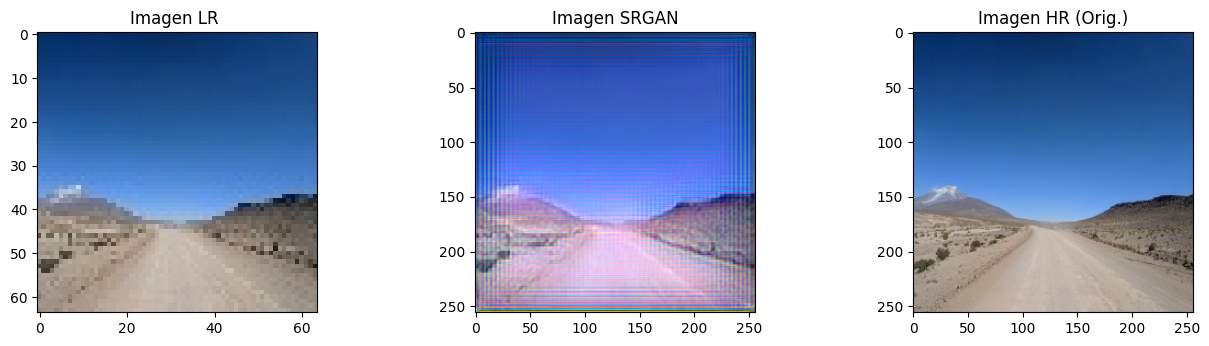

In [ ]:
[X1, X2] = [test_lr, test_hr]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Imagen LR ')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Imagen SRGAN')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Imagen HR (Orig.)')
plt.imshow(tar_image[0,:,:,:])

plt.show()


In [ ]:
batch_size = 1

train_lr_batches = []
train_hr_batches = []

num_batches = int(train_hr.shape[0] / batch_size)

for it in range(num_batches):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batch = train_hr[start_idx:end_idx]
    train_lr_batch = train_lr[start_idx:end_idx]
    train_hr_batches.append(train_hr_batch)
    train_lr_batches.append(train_lr_batch)


In [ ]:
epoch_start = 1020
epoch_end = 1040

for epoch in range(epoch_start, epoch_end):

    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.

    #Create empty lists to populate gen and disc losses.
    g_losses = []
    d_losses = []

    for batch_idx, (lr_images, hr_images) in enumerate(zip(train_lr_batches, train_hr_batches)):

        fake_images = generator.predict_on_batch(lr_images)

        #First, train the discriminator on fake and real HR images.
        discriminator.trainable = True
        discriminator_loss_generated = discriminator.train_on_batch(fake_images, fake_label)
        discriminator_loss_real = discriminator.train_on_batch(hr_images, real_label)

        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False

        #Average the discriminator loss, just for reporting purposes.
        discriminator_loss = 0.5 * np.add(discriminator_loss_generated, discriminator_loss_real)

        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_images)

        #Train the generator via GAN.
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        generator_loss, _, _ = srgan_model.train_on_batch([lr_images, hr_images], [real_label, image_features])

        #Save losses to a list so we can average and report.
        d_losses.append(discriminator_loss)
        g_losses.append(generator_loss)


    #Convert the list of losses to an array to make it easy to average
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    #Calculate the average losses for generator and discriminator
    average_generator_loss = np.sum(g_losses, axis=0) / len(g_losses)
    average_discriminator_loss = np.sum(d_losses, axis=0) / len(d_losses)


    print(f"Epoch {epoch+1}: Generator Loss: {average_generator_loss}, Discriminator Loss: {average_discriminator_loss}")

    if (average_generator_loss < 10):
        discriminator.save_weights(base_path + "/weights/discriminator/d_e_" + str(epoch+1) + ".h5")
        generator.save_weights(base_path + "/weights/generator/g_e_" + str(epoch+1) + ".h5")
        generator.save(base_path + "/model/generator/model_g_e_" + str(epoch+1) + ".h5")
        #discriminator.save(base_path + "/model/discriminator/model_d_e_" + str(epoch+1) + ".h5")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 19ms/step
Epoch 1035: Generator Loss: 14.569526468217372, Discriminator Loss: [0. 1.]
1/1 [==============================] - 0s 31ms/step
Epoch 1036: Generator Loss: 15.692427116259932, Discriminator Loss: [0. 1.]
1/1 [==============================] - 0s 19ms/step
Epoch 1037: Generator Loss: 11.805311063801248, Discriminator Loss: [0. 1.]
1/1 [==============================] - 0s 19ms/step
Epoch 1038: Generator Loss: 12.003848466773828, Discriminator Loss: [0. 1.]
1/1 [==============================] - 0s 21ms/step
Epoch 1039: Generator Loss: 10.808041103680928, Discriminator Loss: [0. 1.]
1/1 [==============================] - 0s 29ms/step
Epoch 1040: Generator Loss: 481.0227860695372, Discriminator Loss: [0. 1.]


In [ ]:
discriminator.save_weights(base_path + "/weights/discriminator/d_e_" + str(epoch+1) + ".h5")
generator.save_weights(base_path + "/weights/generator/g_e_" + str(epoch+1) + ".h5")
generator.save(base_path + "/model/generator/model_g_e_" + str(epoch+1) + ".h5")

In [ ]:
import tensorflow as tf

from numpy.random import randint

generator = tf.keras.models.load_model(base_path + "/model/generator/model_g_e_699_10.60.h5", compile=False)



1/1 [==============================] - 8s 8s/step


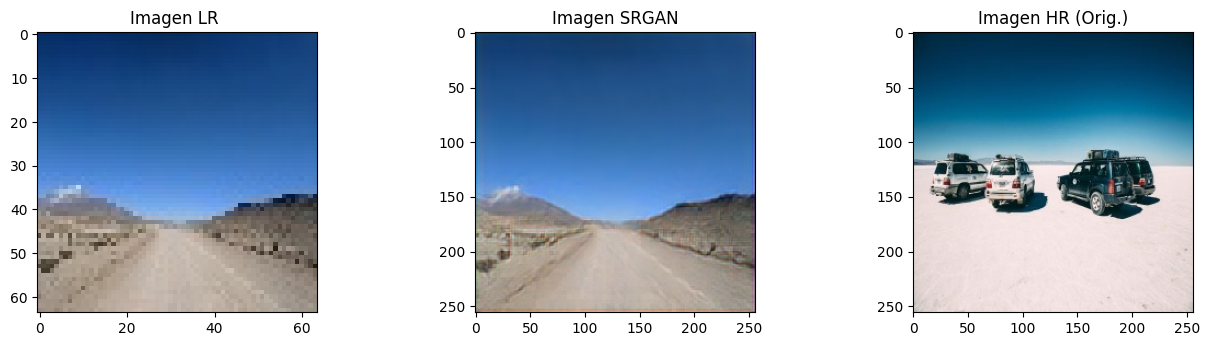

In [ ]:
[X1, X2] = [test_lr, test_hr]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Imagen LR ')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Imagen SRGAN')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Imagen HR (Orig.)')
plt.imshow(tar_image[0,:,:,:])

plt.show()

1/1 [==============================] - 0s 30ms/step


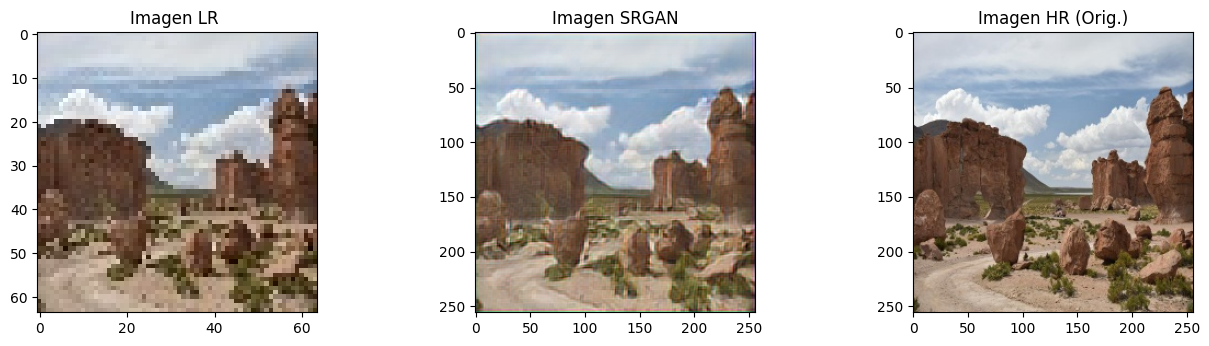

In [ ]:
[X1, X2] = [train_lr, train_hr]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Imagen LR ')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Imagen SRGAN')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Imagen HR (Orig.)')
plt.imshow(tar_image[0,:,:,:])

plt.show()

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

base_path = "/content/drive/My Drive"
dataset_path = os.path.join(base_path, "dataset")
train_hr_path = os.path.join(dataset_path, "train/hr")
train_lr_path = os.path.join(dataset_path, "train/lr")
test_hr_path = os.path.join(dataset_path, "test/hr")
test_lr_path = os.path.join(dataset_path, "test/lr")

In [ ]:
################################################

print(test_lr_path + "/lr_8.jpg")
print(test_hr_path + "/hr_8.jpg")

/content/drive/My Drive/dataset/test/lr/lr_8.jpg
/content/drive/My Drive/dataset/test/hr/hr_8.jpg


In [ ]:
################################################
sreeni_lr = cv2.imread(test_lr_path + "/lr_8.jpg")
sreeni_hr = cv2.imread(test_hr_path + "/hr_8.jpg")

#Change images from BGR to RGB for plotting.
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

1/1 [==============================] - 0s 28ms/step


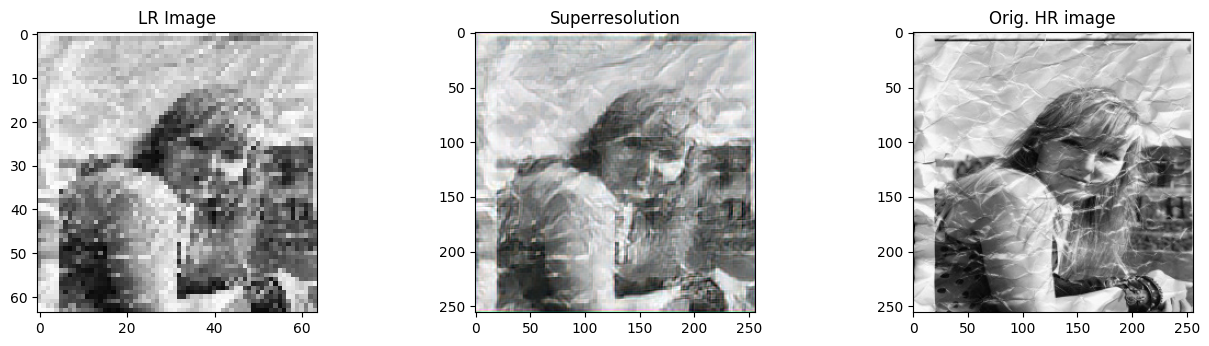

In [ ]:
# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()